In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive # Load data
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/Masters/Santander Customer Satisfaction - TRAIN.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Masters/Santander Customer Satisfaction - TEST-Without TARGET.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check for missing values and general info
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None
                  ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529

In [4]:
print(train_data.isna().sum())

ID                         0
var3                       0
var15                      0
imp_ent_var16_ult1         0
imp_op_var39_comer_ult1    0
                          ..
saldo_medio_var44_hace3    0
saldo_medio_var44_ult1     0
saldo_medio_var44_ult3     0
var38                      0
TARGET                     0
Length: 371, dtype: int64


TARGET
0    73012
1     3008
Name: count, dtype: int64


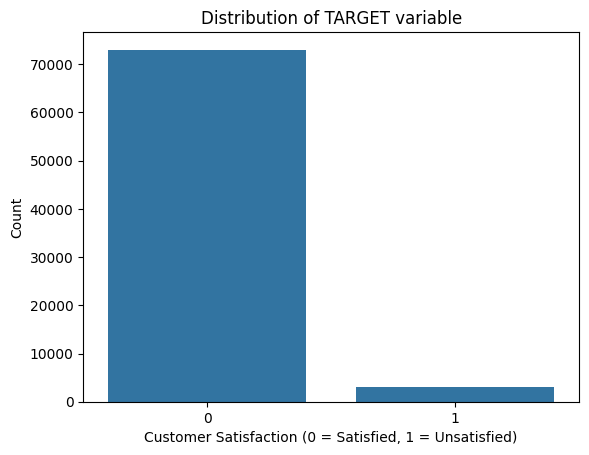

In [7]:
# Plot the distribution of the target variable
sns.countplot(x='TARGET', data=train_data)
plt.title('Distribution of TARGET variable')
plt.xlabel('Customer Satisfaction (0 = Satisfied, 1 = Unsatisfied)')
plt.ylabel('Count')
print(train_data['TARGET'].value_counts())
plt.show()

In [8]:
#specifying the target variable
Y = train_data['TARGET']  # Target variable
X = train_data.drop(columns=['TARGET'])  # Features
X_test = test_data

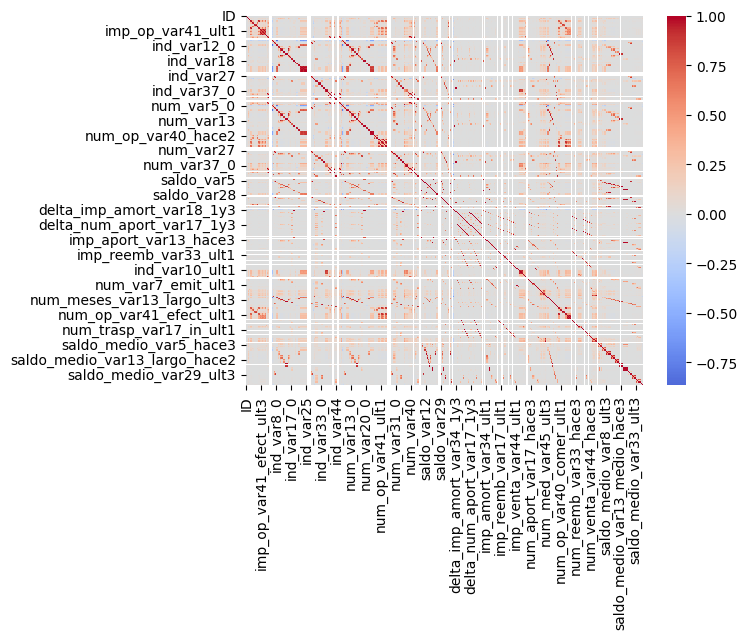

In [9]:
# Visualize correlation matrix
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.show()

In [10]:
# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

# Baseline model - Initialize the Decision Tree Classifier with default parameters
clf_baseline = DecisionTreeClassifier(random_state=42)
clf_baseline.fit(x_train, y_train)

# Predictions
y_pred_baseline = clf_baseline.predict_proba(x_val)[:,1]

# Evaluate
auc_baseline = roc_auc_score(y_val, y_pred_baseline)
print(f'Baseline Model AUC: {auc_baseline:.4f}')
print("depth",clf_baseline.get_depth())
print("leaf",clf_baseline.get_n_leaves())

Baseline Model AUC: 0.5519
depth 65
leaf 3507


In [11]:
# Feature Importance
importances = clf_baseline.feature_importances_
feature_importance_df = pd.DataFrame({'feature': x_train.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print("Top 3 irrelevant features:\n\n", feature_importance_df.tail(3))
print("\nTop 3 relevant features:\n", feature_importance_df.head(3))


Top 3 irrelevant features:

          feature  importance
145    num_var33         0.0
144  num_var33_0         0.0
185  saldo_var32         0.0

Top 3 relevant features:
     feature  importance
0        ID    0.265433
369   var38    0.216396
2     var15    0.137290


In [ ]:
# # Filter features based on importance score
# important_features = feature_importance_df[(feature_importance_df['importance'] >= 0.001) | (feature_importance_df['feature'] == 'ID')]['feature'].tolist()

# # Update training and testing datasets
# x_train = x_train[important_features]
# x_val = x_val[important_features]
# x_test = X_test[important_features]

# clf_baseline = DecisionTreeClassifier(random_state=42)
# clf_baseline.fit(x_train, y_train)

# # Predictions
# y_pred_baseline = clf_baseline.predict_proba(x_val)[:,1]

# # Evaluate
# auc_baseline = roc_auc_score(y_val, y_pred_baseline)
# print(f'Baseline Model AUC: {auc_baseline:.4f}')

# print("depth",clf_baseline.get_depth())
# print("leaf",clf_baseline.get_n_leaves())

Baseline Model AUC: 0.5492
depth 57
leaf 3511


In [22]:
# Model with limited depth
depth_clf = DecisionTreeClassifier(max_depth=8,random_state=42)
depth_clf.fit(x_train, y_train)

# Predictions
y_depth_pred = depth_clf.predict_proba(x_val)[:,1]

# Evaluate
depth_auc = roc_auc_score(y_val, y_depth_pred)
print(f'Model with max_depth=5 AUC: {depth_auc:.4f}')


Model with max_depth=5 AUC: 0.8261


In [14]:
# Model with limited leaf nodes
leaf_clf = DecisionTreeClassifier(max_leaf_nodes=52, random_state=42)
leaf_clf.fit(x_train, y_train)

# Predictions
y_leaf_pred = leaf_clf.predict_proba(x_val)[:,1]

# Evaluate
leaf_auc = roc_auc_score(y_val, y_leaf_pred)
print(f'Model with max_leaf_nodes=10 AUC: {leaf_auc:.4f}')

Model with max_leaf_nodes=10 AUC: 0.8209


In [15]:
# Model using entropy criterion
entropy_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
entropy_clf.fit(x_train, y_train)

# Predictions
y_entropy_pred = entropy_clf.predict_proba(x_val)[:,1]

# Evaluate
auc_entropy = roc_auc_score(y_val, y_entropy_pred)
print(f'Model with criterion="entropy" AUC: {auc_entropy:.4f}')


Model with criterion="entropy" AUC: 0.5499


In [23]:
# Make predictions on test set
# y_test_pred = clf.predict(X_test)
X_test = X_test[depth_clf.feature_names_in_]
y_test_pred = depth_clf.predict_proba(X_test)[:,1]

prediction_df = pd.DataFrame({'ID': X_test['ID'], 'TARGET': y_test_pred})

# Store y_test_pred to data file
file_name = f'/content/drive/MyDrive/Masters/prediction_Data_depth.csv'
prediction_df.to_csv(file_name, index=False)
print(f"Predictions saved to {file_name}")

# Perform cross-validation
cv_scores = cross_val_score(depth_clf, x_train, y_train, cv=5, scoring='accuracy')
mean_cv_score = np.mean(cv_scores)
print(f"Cross-Validation Accuracy with params: {mean_cv_score:.2f}")

# Get probability scores to analyze model uncertainty
y_proba = depth_clf.predict_proba(X_test)

# Print model performance insights
print(f"Model performance with params:")
# print(f"Predicted class counts: {np.bincount(y_pred)}")
print("Probability Scores (first few samples):")
print(y_proba[:5])  # Show uncertainty scores for the first few test samples
print("------------------------------------------------------")

Predictions saved to /content/drive/MyDrive/Masters/prediction_Data_depth.csv
Cross-Validation Accuracy with params: 0.96
Model performance with params:
Probability Scores (first few samples):
[[0.96644295 0.03355705]
 [0.96644295 0.03355705]
 [0.99804022 0.00195978]
 [0.99358387 0.00641613]
 [0.99804022 0.00195978]]
------------------------------------------------------


In [26]:
print("depth",depth_clf.get_depth())
print("leaf",depth_clf.get_n_leaves())

depth 8
leaf 113


In [16]:
# Make predictions on test set
# y_test_pred = clf.predict(X_test)
X_test = X_test[depth_clf.feature_names_in_]
y_test_pred = leaf_clf.predict_proba(X_test)[:,1]

prediction_df = pd.DataFrame({'ID': X_test['ID'], 'TARGET': y_test_pred})

# Store y_test_pred to data file
file_name = f'/content/drive/MyDrive/Masters/prediction_Data_leaf.csv'
prediction_df.to_csv(file_name, index=False)
print(f"Predictions saved to {file_name}")

# Perform cross-validation
cv_scores = cross_val_score(leaf_clf, x_train, y_train, cv=5, scoring='accuracy')
mean_cv_score = np.mean(cv_scores)
print(f"Cross-Validation Accuracy with params: {mean_cv_score:.2f}")

# Get probability scores to analyze model uncertainty
y_proba = leaf_clf.predict_proba(X_test)

# Print model performance insights
print(f"Model performance with params:")
# print(f"Predicted class counts: {np.bincount(y_pred)}")
print("Probability Scores (first few samples):")
print(y_proba[:5])  # Show uncertainty scores for the first few test samples
print("------------------------------------------------------")

Predictions saved to /content/drive/MyDrive/Masters/prediction_Data_leaf.csv
Cross-Validation Accuracy with params: 0.96
Model performance with params:
Probability Scores (first few samples):
[[0.96602013 0.03397987]
 [0.96602013 0.03397987]
 [0.99417839 0.00582161]
 [0.98097087 0.01902913]
 [0.99417839 0.00582161]]
------------------------------------------------------
